<a href="https://colab.research.google.com/github/leonardooliveiraoficial/mba-data-projects/blob/main/projeto_comercial/vendas_imobiliarias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case BI – Vendas Imobiliárias**

> Linguagem Python



## **1. Importar bibliotecas**

In [64]:
!pip -q install openpyxl unidecode

import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

REF_DATE = pd.Timestamp("2023-09-30")


## **2. Leitura das bases**

In [65]:
vendas   = pd.read_excel("dataset_venda.xlsx")
cidades  = pd.read_excel("dataset_cidades.xlsx")
empreend = pd.read_excel("dataset_empreendimento.xlsx")

print("Shapes → vendas, cidades, empreendimentos:", vendas.shape, cidades.shape, empreend.shape)


Shapes → vendas, cidades, empreendimentos: (31798, 3) (140, 3) (1274, 7)


## **3. Padronização de colunas**

In [66]:
def standardize_columns(df):
    df = df.copy()
    new_cols = []
    for c in df.columns:
        c2 = unidecode(str(c)).strip().lower()
        c2 = re.sub(r"[^a-z0-9]+", "_", c2)
        c2 = re.sub(r"_+", "_", c2).strip("_")
        new_cols.append(c2)
    df.columns = new_cols
    return df

vendas   = standardize_columns(vendas)
cidades  = standardize_columns(cidades)
empreend = standardize_columns(empreend)

print("\nCOLUNAS PADRONIZADAS")
print("VENDAS:", vendas.columns.tolist())
print("CIDADES:", cidades.columns.tolist())
print("EMPREENDIMENTOS:", empreend.columns.tolist())



COLUNAS PADRONIZADAS
VENDAS: ['identificador_empreendimento', 'data_base', 'vendas']
CIDADES: ['identificador', 'cidade', 'regional']
EMPREENDIMENTOS: ['identificador_empreendimento', 'identificador_cidade', 'total_apartamento', 'data_prevista_inicio_obra', 'data_inicio_obra', 'data_prevista_fim_obra', 'data_fim_obra']


## **4. Integração**

In [67]:
# Mapeamento fixo
ID_EMP_V   = "identificador_empreendimento"  # vendas
ID_EMP_E   = "identificador_empreendimento"  # empreendimentos
EMP_CITY   = "identificador_cidade"          # empreendimentos
CITY_ID    = "identificador"                 # cidades
CITY_NAME  = "cidade"                        # cidades
REGIONAL   = "regional"                      # cidades
DATA_VENDA = "data_base"                     # vendas
TOTAL_APT  = "total_apartamento"             # empreendimentos

DATA_INICIO_OBRA      = "data_inicio_obra"
DATA_FIM_OBRA         = "data_fim_obra"
DATA_PREV_INICIO_OBRA = "data_prevista_inicio_obra"
DATA_PREV_FIM_OBRA    = "data_prevista_fim_obra"

# Parse datas
for col in [DATA_VENDA, DATA_INICIO_OBRA, DATA_FIM_OBRA, DATA_PREV_INICIO_OBRA, DATA_PREV_FIM_OBRA]:
    if col in vendas.columns:
        vendas[col] = pd.to_datetime(vendas[col], errors="coerce")
    if col in empreend.columns:
        empreend[col] = pd.to_datetime(empreend[col], errors="coerce")

# Vendas + Empreendimentos
cols_emp_keep = [ID_EMP_E, EMP_CITY]
if TOTAL_APT in empreend.columns:
    cols_emp_keep += [TOTAL_APT]
for c in [DATA_INICIO_OBRA, DATA_FIM_OBRA, DATA_PREV_INICIO_OBRA, DATA_PREV_FIM_OBRA]:
    if c in empreend.columns:
        cols_emp_keep += [c]
cols_emp_keep = list(dict.fromkeys([c for c in cols_emp_keep if c in empreend.columns]))

df = vendas.merge(empreend[cols_emp_keep], left_on=ID_EMP_V, right_on=ID_EMP_E, how="left")

# + Cidades (nome / regional)
cols_city_keep = [CITY_ID]
if CITY_NAME in cidades.columns:
    cols_city_keep += [CITY_NAME]
if REGIONAL in cidades.columns:
    cols_city_keep += [REGIONAL]
cols_city_keep = [c for c in cols_city_keep if c in cidades.columns]

df = df.merge(cidades[cols_city_keep], left_on=EMP_CITY, right_on=CITY_ID, how="left")

print("\nShape final da base integrada:", df.shape)
display(df.head(5))



Shape final da base integrada: (31817, 12)


,identificador_empreendimento,data_base,vendas,identificador_cidade,total_apartamento,data_inicio_obra,data_fim_obra,data_prevista_inicio_obra,data_prevista_fim_obra,identificador,cidade,regional
0,028BBEBD-36C9-E711-B989-80C16E075108,2021-01-01,1,28,155,2020-12-31,2021-07-01,2020-04-01,2021-07-01,28,Suzano,São Paulo
1,028BBEBD-36C9-E711-B989-80C16E075108,2021-02-01,3,28,155,2020-12-31,2021-07-01,2020-04-01,2021-07-01,28,Suzano,São Paulo
2,028BBEBD-36C9-E711-B989-80C16E075108,2021-05-01,2,28,155,2020-12-31,2021-07-01,2020-04-01,2021-07-01,28,Suzano,São Paulo
3,028BBEBD-36C9-E711-B989-80C16E075108,2021-09-01,1,28,155,2020-12-31,2021-07-01,2020-04-01,2021-07-01,28,Suzano,São Paulo
4,028BBEBD-36C9-E711-B989-80C16E075108,2021-11-01,1,28,155,2020-12-31,2021-07-01,2020-04-01,2021-07-01,28,Suzano,São Paulo


## **5. Limpeza e derivados**

In [68]:
# Fallback: se não existir coluna 'vendas' (unidades), usa 1 por linha
if "vendas" not in df.columns:
    df["vendas"] = 1

# Remove vendas negativas (qualidade)
df = df[df["vendas"] >= 0].copy()

# Flag/filtro data de referência
df["ate_ref"] = (df.get(DATA_VENDA) <= REF_DATE) if DATA_VENDA in df.columns else True
df_ref = df[df["ate_ref"]].copy()  # <<< tudo que é "situação atual" usa df_ref


## **6. KPIs (usando df_ref)**

In [69]:
def group_sum(df_, key):
    return (df_.groupby(key)["vendas"]
              .sum().sort_values(ascending=False)
              .reset_index(name="unidades_vendidas"))

# Cidade
ch_city = CITY_NAME if CITY_NAME in df_ref.columns else EMP_CITY
vendas_por_cidade = group_sum(df_ref, ch_city)

# Regional
if REGIONAL in df_ref.columns:
    vendas_por_regional = group_sum(df_ref, REGIONAL)
else:
    vendas_por_regional = pd.DataFrame()

# Curva mensal (geral)
if DATA_VENDA in df_ref.columns:
    df_ref["ano_mes"] = df_ref[DATA_VENDA].dt.to_period("M").astype(str)
    vendas_por_mes = (df_ref.groupby("ano_mes")["vendas"]
                      .sum().reset_index(name="unidades"))
else:
    vendas_por_mes = pd.DataFrame()


## **7. Painel por empreendimento**

In [70]:
# Vendido total até REF_DATE
acum_emp_ref = (df_ref.groupby(ID_EMP_V)["vendas"].sum()
                 .rename("vendido_total").reset_index())

# Total de aptos (catálogo)
if TOTAL_APT in empreend.columns:
    totais_emp = empreend[[ID_EMP_E, TOTAL_APT]].copy()
else:
    totais_emp = pd.DataFrame({ID_EMP_E: df_ref[ID_EMP_V].unique(), TOTAL_APT: np.nan})

painel_emp = acum_emp_ref.merge(totais_emp, left_on=ID_EMP_V, right_on=ID_EMP_E, how="left")

if TOTAL_APT in painel_emp.columns:
    painel_emp["pct_vendido"] = painel_emp["vendido_total"] / painel_emp[TOTAL_APT]
    painel_emp["pct_vendido"] = painel_emp["pct_vendido"].clip(upper=1.5)  # limita explosões
    painel_emp["estoque"]     = painel_emp[TOTAL_APT] - painel_emp["vendido_total"]
else:
    painel_emp["pct_vendido"] = np.nan
    painel_emp["estoque"]     = np.nan

display(painel_emp.head(10))


,identificador_empreendimento,vendido_total,total_apartamento,pct_vendido,estoque
0,01D9C148-3D5B-E711-BB04-DB6828735DB2,92,92,1.000000,0
1,028BBEBD-36C9-E711-B989-80C16E075108,30,155,0.193548,125
2,0458C53A-F8CC-DC11-9ED6-001B7845B4A6,134,160,0.837500,26
3,0585C6A2-3975-DD11-8A4F-001B78B9D994,81,120,0.675000,39
4,0590CD62-3ADB-E111-A5A4-001F2909E810,88,130,0.676923,42
5,06F8DCDC-55D7-E111-BBED-001F2909E810,54,54,1.000000,0
6,0867BF7E-EEDB-E511-B93A-80C16E075108,78,78,1.000000,0
7,099694DB-5116-DF11-83FF-001F2909E810,78,78,1.000000,0
8,09E3AAFC-0D1C-E411-B03C-80C16E075108,46,46,1.000000,0
9,0A6741F5-B44F-E411-B03C-80C16E075108,146,160,0.912500,14


## **8. Velocidade: dias até 100%**

In [71]:
def dias_para_100(grp):
    if DATA_VENDA not in grp.columns or TOTAL_APT not in grp.columns:
        return pd.Series({"dias_ate_100": np.nan, "data_100": pd.NaT})
    g = grp.sort_values(DATA_VENDA)
    g["cum"] = g["vendas"].cumsum()
    total = g[TOTAL_APT].iloc[0] if TOTAL_APT in g.columns else np.nan
    if pd.isna(total) or total <= 0:  # sem total
        return pd.Series({"dias_ate_100": np.nan, "data_100": pd.NaT})
    atingiu = g[g["cum"] >= total]
    if atingiu.empty:  # não atingiu 100%
        return pd.Series({"dias_ate_100": np.nan, "data_100": pd.NaT})
    data100 = atingiu.iloc[0][DATA_VENDA]
    # data de início real (se houver), senão 1ª venda
    data_inicio = grp[DATA_INICIO_OBRA].iloc[0] if DATA_INICIO_OBRA in grp.columns else g[DATA_VENDA].min()
    if pd.isna(data_inicio) or pd.isna(data100):
        return pd.Series({"dias_ate_100": np.nan, "data_100": data100})
    return pd.Series({"dias_ate_100": (data100 - data_inicio).days, "data_100": data100})

# Para velocidade, usando todo o histórico (df), não só df_ref
if DATA_VENDA in df.columns:
    tmp = df.merge(empreend[[ID_EMP_E, TOTAL_APT] + [c for c in [DATA_INICIO_OBRA] if c in empreend.columns]],
                   left_on=ID_EMP_V, right_on=ID_EMP_E, how="left")
    vel = tmp.groupby(ID_EMP_V).apply(dias_para_100).reset_index()
    painel_emp = painel_emp.merge(vel, on=ID_EMP_V, how="left")
else:
    painel_emp["dias_ate_100"] = np.nan
    painel_emp["data_100"] = pd.NaT

display(painel_emp.sort_values("dias_ate_100").head(10))


/tmp/ipython-input-2115809990.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vel = tmp.groupby(ID_EMP_V).apply(dias_para_100).reset_index()


,identificador_empreendimento,vendido_total,total_apartamento,pct_vendido,estoque,dias_ate_100,data_100
0,01D9C148-3D5B-E711-BB04-DB6828735DB2,92,92,1.000000,0,NaT,NaT
1,028BBEBD-36C9-E711-B989-80C16E075108,30,155,0.193548,125,NaT,NaT
2,0458C53A-F8CC-DC11-9ED6-001B7845B4A6,134,160,0.837500,26,NaT,NaT
3,0585C6A2-3975-DD11-8A4F-001B78B9D994,81,120,0.675000,39,NaT,NaT
4,0590CD62-3ADB-E111-A5A4-001F2909E810,88,130,0.676923,42,NaT,NaT
5,06F8DCDC-55D7-E111-BBED-001F2909E810,54,54,1.000000,0,NaT,NaT
6,0867BF7E-EEDB-E511-B93A-80C16E075108,78,78,1.000000,0,NaT,NaT
7,099694DB-5116-DF11-83FF-001F2909E810,78,78,1.000000,0,NaT,NaT
8,09E3AAFC-0D1C-E411-B03C-80C16E075108,46,46,1.000000,0,NaT,NaT
9,0A6741F5-B44F-E411-B03C-80C16E075108,146,160,0.912500,14,NaT,NaT


## **9. Absorção mensal**



In [72]:
if DATA_VENDA in df_ref.columns and TOTAL_APT in empreend.columns:
    df_ref["ano_mes"] = df_ref[DATA_VENDA].dt.to_period("M").astype(str)
    base_abs = (df_ref.groupby([ID_EMP_V, "ano_mes"])["vendas"].sum()
                .reset_index(name="unid_mes"))
    base_abs = base_abs.merge(empreend[[ID_EMP_E, TOTAL_APT]], left_on=ID_EMP_V, right_on=ID_EMP_E, how="left")
    base_abs["absorcao_mensal"] = base_abs["unid_mes"] / base_abs[TOTAL_APT]
    absorcao_media_emp = (base_abs.groupby(ID_EMP_V)["absorcao_mensal"]
                          .mean().reset_index(name="absorcao_media"))
else:
    base_abs = pd.DataFrame()
    absorcao_media_emp = pd.DataFrame()

display(base_abs.head(10))


,identificador_empreendimento,ano_mes,unid_mes,total_apartamento,absorcao_mensal
0,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-01,5,92,0.054348
1,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-02,3,92,0.032609
2,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-03,3,92,0.032609
3,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-04,5,92,0.054348
4,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-05,5,92,0.054348
5,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-06,6,92,0.065217
6,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-07,6,92,0.065217
7,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-08,5,92,0.054348
8,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-09,3,92,0.032609
9,01D9C148-3D5B-E711-BB04-DB6828735DB2,2021-10,5,92,0.054348


## **10. Curva por regional**



In [73]:
if DATA_VENDA in df_ref.columns and REGIONAL in df_ref.columns:
    df_ref["ano_mes"] = df_ref[DATA_VENDA].dt.to_period("M").astype(str)
    vendas_mes_reg = (df_ref.groupby(["ano_mes", REGIONAL])["vendas"]
                      .sum().reset_index(name="unidades"))
else:
    vendas_mes_reg = pd.DataFrame()

display(vendas_mes_reg.head(10))


,ano_mes,regional,unidades
0,2021-01,Amazonas,2
1,2021-01,Belo Horizonte,346
2,2021-01,Brasília,78
3,2021-01,Campinas,382
4,2021-01,Centro Oeste,82
5,2021-01,Curitiba,334
6,2021-01,Nordeste,262
7,2021-01,Porto Alegre,100
8,2021-01,Ribeirão Preto,436
9,2021-01,Rio de Janeiro,168


## **11. Outliers & Risco**

In [74]:
outliers = []
if "pct_vendido" in painel_emp.columns:
    ovr = painel_emp[painel_emp["pct_vendido"] > 1.001][[ID_EMP_V, "vendido_total", TOTAL_APT, "pct_vendido"]]
    if not ovr.empty:
        outliers.append(("pct_vendido>100%", ovr))

# Alerta de risco
riscos = pd.DataFrame()
if {"pct_vendido","estoque"}.issubset(painel_emp.columns):
    riscos = painel_emp[(painel_emp["pct_vendido"] >= 0.90) | (painel_emp["estoque"] <= 10)]
display(riscos.head(10))


,identificador_empreendimento,vendido_total,total_apartamento,pct_vendido,estoque,dias_ate_100,data_100
0,01D9C148-3D5B-E711-BB04-DB6828735DB2,92,92,1.0000,0,NaT,NaT
5,06F8DCDC-55D7-E111-BBED-001F2909E810,54,54,1.0000,0,NaT,NaT
6,0867BF7E-EEDB-E511-B93A-80C16E075108,78,78,1.0000,0,NaT,NaT
7,099694DB-5116-DF11-83FF-001F2909E810,78,78,1.0000,0,NaT,NaT
8,09E3AAFC-0D1C-E411-B03C-80C16E075108,46,46,1.0000,0,NaT,NaT
9,0A6741F5-B44F-E411-B03C-80C16E075108,146,160,0.9125,14,NaT,NaT
17,0E57A4F8-B7E8-DD11-BD2B-001B78B9D994,70,70,1.0000,0,NaT,NaT
18,1091BC92-94AD-E011-8272-001F2909E810,44,44,1.0000,0,NaT,NaT
29,1288ED15-7CB9-E711-B989-80C16E075108,50,50,1.0000,0,NaT,NaT
32,142A596E-9FD9-DC11-ABCF-001B7845B4A6,63,63,1.0000,0,NaT,NaT


## **12. Gráficos**

### **12.1 Unidades vendidas por cidade (Top 10)**

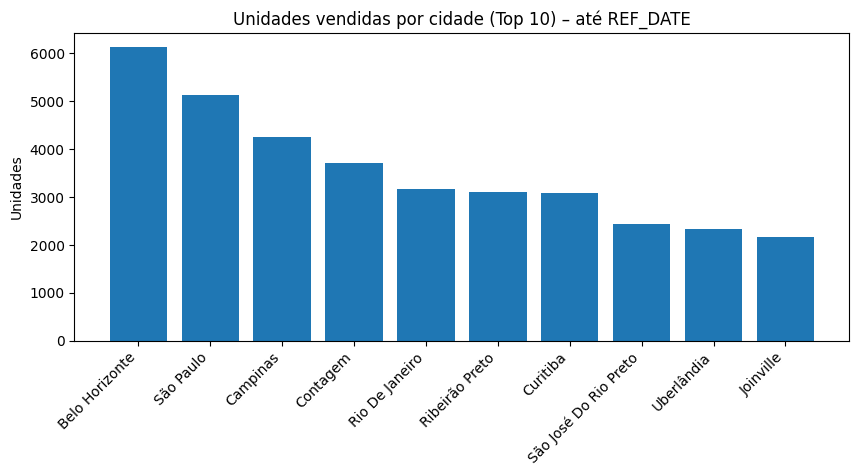

In [75]:
plt.figure(figsize=(10,4))
plt.title("Unidades vendidas por cidade (Top 10) – até REF_DATE")
plot_df = vendas_por_cidade.head(10)
plt.bar(plot_df[ch_city].astype(str), plot_df["unidades_vendidas"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Unidades"); plt.show()

### **12.2 Unidades vendidas por regional**

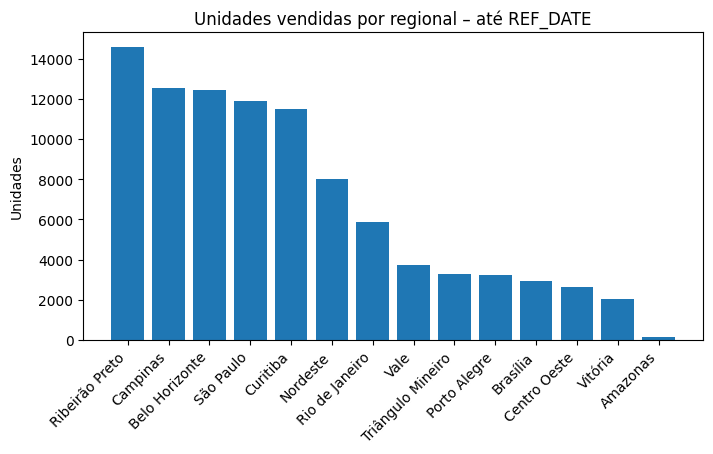

In [76]:
if not vendas_por_regional.empty:
    plt.figure(figsize=(8,4))
    plt.title("Unidades vendidas por regional – até REF_DATE")
    plt.bar(vendas_por_regional[REGIONAL].astype(str), vendas_por_regional["unidades_vendidas"])
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Unidades"); plt.show()

### **12.3 Curva mensal de vendas (unidades)**

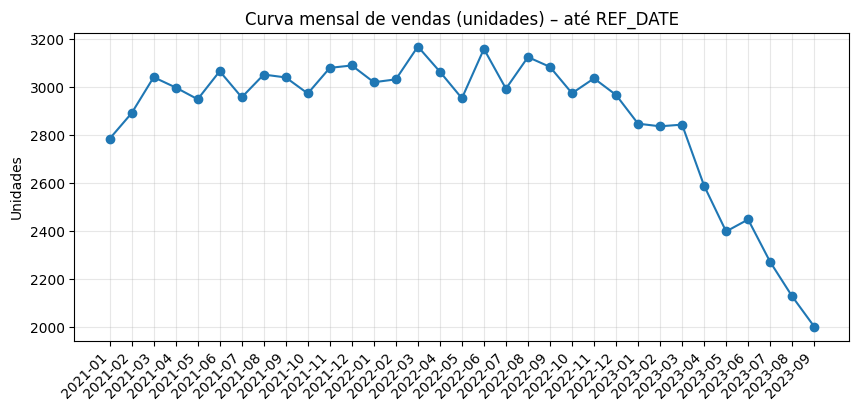

In [77]:
if not vendas_por_mes.empty:
    plt.figure(figsize=(10,4))
    plt.title("Curva mensal de vendas (unidades) – até REF_DATE")
    plt.plot(vendas_por_mes["ano_mes"], vendas_por_mes["unidades"], marker="o")
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Unidades"); plt.grid(True, alpha=.3); plt.show()

### **12.4 Top empreendimentos por volume**

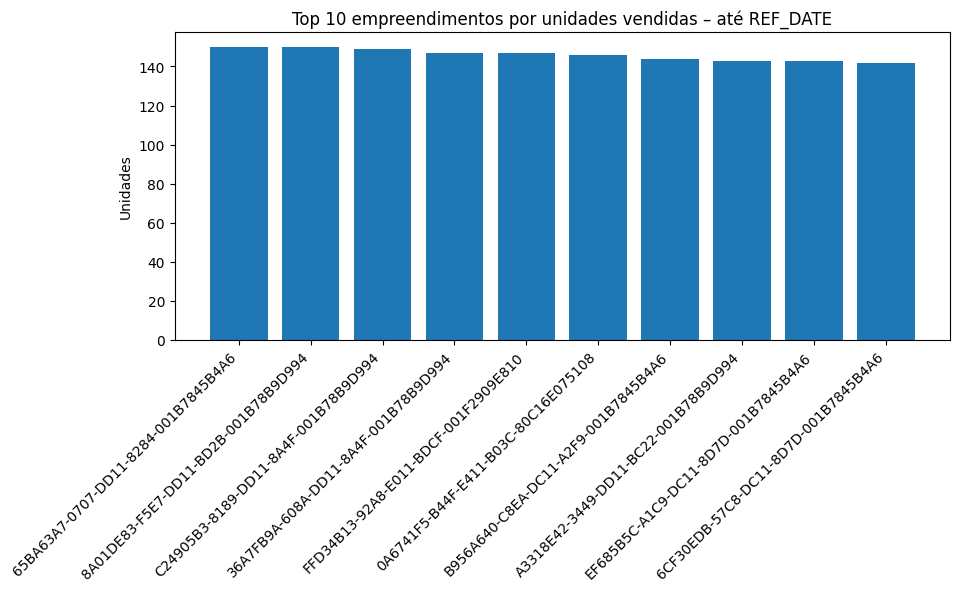

In [78]:
plt.figure(figsize=(10,4))
plt.title("Top 10 empreendimentos por unidades vendidas – até REF_DATE")
top_emp = painel_emp.sort_values("vendido_total", ascending=False).head(10)
plt.bar(top_emp[ID_EMP_V].astype(str), top_emp["vendido_total"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Unidades"); plt.show()

### **12.5 % vendido por empreendimento (Top 10)**

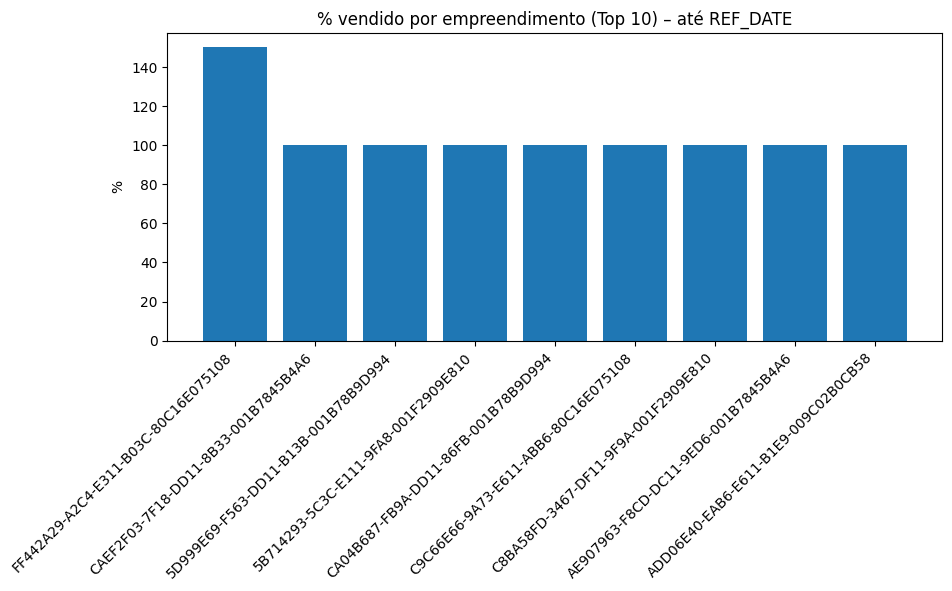

In [79]:
# % vendido (foto em REF_DATE)
if "pct_vendido" in painel_emp.columns:
    plt.figure(figsize=(10,4))
    plt.title("% vendido por empreendimento (Top 10) – até REF_DATE")
    top_pct = painel_emp.sort_values("pct_vendido", ascending=False).head(10)
    plt.bar(top_pct[ID_EMP_V].astype(str), (top_pct["pct_vendido"]*100))
    plt.xticks(rotation=45, ha="right"); plt.ylabel("%"); plt.show()

## **13. Insights**

In [80]:
insights = []

if not vendas_por_cidade.empty:
    top_city = vendas_por_cidade.iloc[0]
    insights.append(f"- 📍 Cidade com mais unidades (até {REF_DATE.date()}): **{top_city[ch_city]}** ({int(top_city['unidades_vendidas'])}).")

if not vendas_por_regional.empty:
    top_reg = vendas_por_regional.iloc[0]
    insights.append(f"- 🗺️ Regional com maior volume: **{top_reg[REGIONAL]}** ({int(top_reg['unidades_vendidas'])}).")

if not painel_emp.empty:
    top_emp_un = painel_emp.sort_values("vendido_total", ascending=False).iloc[0]
    insights.append(f"- 🏢 Empreendimento com maior volume: **{top_emp_un[ID_EMP_V]}** ({int(top_emp_un['vendido_total'])}).")

    if painel_emp["pct_vendido"].notna().any():
        top_pct = painel_emp.sort_values("pct_vendido", ascending=False).iloc[0]
        insights.append(f"- ✅ Maior % vendido: **{top_pct[ID_EMP_V]}** ({top_pct['pct_vendido']*100:.1f}%).")

    if "dias_ate_100" in painel_emp.columns and painel_emp["dias_ate_100"].notna().any():
        fast = painel_emp.sort_values("dias_ate_100").dropna(subset=["dias_ate_100"])
        if not fast.empty:
            f1 = fast.iloc[0]
            insights.append(f"- ⚡ Mais rápido a 100%: **{f1[ID_EMP_V]}** ({int(f1['dias_ate_100'])} dias).")

if not base_abs.empty:
    top_abs = base_abs.sort_values("absorcao_mensal", ascending=False).head(1)
    if not top_abs.empty:
        r = top_abs.iloc[0]
        insights.append(f"- 📈 Maior absorção mensal: **{r[ID_EMP_V]}** ({r['absorcao_mensal']*100:.1f}% do estoque no mês {r['ano_mes']}).")

if not riscos.empty:
    insights.append(f"- ⚠️ Risco de ruptura/esgotamento: {len(riscos)} empreendimento(s) com estoque baixo ou ≥90% vendido.")

if outliers:
    insights.append(f"- ❗ Possíveis inconsistências: {', '.join([tag for tag,_ in outliers])} (ver CSV de outliers).")

print("\n🧭 Insights iniciais:")
print("\n".join(insights) if insights else "Sem insights automáticos.")



🧭 Insights iniciais:
- 📍 Cidade com mais unidades (até 2023-09-30): **Belo Horizonte** (6126).
- 🗺️ Regional com maior volume: **Ribeirão Preto** (14605).
- 🏢 Empreendimento com maior volume: **65BA63A7-0707-DD11-8284-001B7845B4A6** (150).
- ✅ Maior % vendido: **FF442A29-A2C4-E311-B03C-80C16E075108** (150.0%).
- 📈 Maior absorção mensal: **FF442A29-A2C4-E311-B03C-80C16E075108** (17.2% do estoque no mês 2021-07).
- ⚠️ Risco de ruptura/esgotamento: 438 empreendimento(s) com estoque baixo ou ≥90% vendido.
- ❗ Possíveis inconsistências: pct_vendido>100% (ver CSV de outliers).


## **13. Export CSVs**

In [81]:
vendas_por_cidade.to_csv("kpi_vendas_por_cidade.csv", index=False)
if not vendas_por_regional.empty:
    vendas_por_regional.to_csv("kpi_vendas_por_regional.csv", index=False)
if not vendas_por_mes.empty:
    vendas_por_mes.to_csv("kpi_vendas_por_mes.csv", index=False)

painel_emp.to_csv("kpi_painel_empreendimentos.csv", index=False)
if not base_abs.empty:
    base_abs.to_csv("kpi_absorcao_mensal_por_emp.csv", index=False)
if not absorcao_media_emp.empty:
    absorcao_media_emp.to_csv("kpi_absorcao_media_emp.csv", index=False)
if not vendas_mes_reg.empty:
    vendas_mes_reg.to_csv("kpi_vendas_mensal_por_regional.csv", index=False)

if outliers:
    outliers[0][1].to_csv("qualidade_outliers_pct_mais_que_100.csv", index=False)
if not riscos.empty:
    riscos.to_csv("alerta_risco_esgotamento.csv", index=False)

print("\n📁 CSVs exportados (conforme disponibilidade):")
print("- kpi_vendas_por_cidade.csv")
print("- kpi_vendas_por_regional.csv")
print("- kpi_vendas_por_mes.csv")
print("- kpi_painel_empreendimentos.csv")
print("- kpi_absorcao_mensal_por_emp.csv")
print("- kpi_absorcao_media_emp.csv")
print("- kpi_vendas_mensal_por_regional.csv")
print("- qualidade_outliers_pct_mais_que_100.csv")
print("- alerta_risco_esgotamento.csv")



📁 CSVs exportados (conforme disponibilidade):
- kpi_vendas_por_cidade.csv
- kpi_vendas_por_regional.csv
- kpi_vendas_por_mes.csv
- kpi_painel_empreendimentos.csv
- kpi_absorcao_mensal_por_emp.csv
- kpi_absorcao_media_emp.csv
- kpi_vendas_mensal_por_regional.csv
- qualidade_outliers_pct_mais_que_100.csv
- alerta_risco_esgotamento.csv
